In [26]:
import os
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [27]:
# Configuración general
folder_path = r"/home/alkain/Escritorio/Github_Repositorios/Microgrid/TrainTestSplit"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
# Función para cargar y preprocesar datos (usada tanto para entrenamiento como para test)
def load_and_preprocess(files, all_sources):
    df_list = []
    for file in files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path, parse_dates=["Time Stamp (local standard time) yyyy-mm-ddThh:mm:ss"])
        df = df.drop(columns='Time Stamp (local standard time) yyyy-mm-ddThh:mm:ss')
        # Muestreo estratificado
        df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))
        df_list.append(df_sampled)
    full_df = pd.concat(df_list, ignore_index=True)
    
    # One-hot encoding con categorías fijas
    full_df['source'] = pd.Categorical(full_df['source'], categories=all_sources)
    full_df = pd.get_dummies(full_df, columns=['source'], prefix='src', dtype=np.float32)
    
    return full_df


In [29]:
# Función para preparar tensores a partir de DataFrame
def prepare_data(df, scaler=None):
    # Separar características y target
    X = df.drop(columns=['Pmp (W)']).values.astype(np.float32)
    y = df['Pmp (W)'].values.astype(np.float32)
    if scaler is None:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    else:
        X = scaler.transform(X)
    X_tensor = torch.tensor(X).to(device)
    y_tensor = torch.tensor(y).unsqueeze(1).to(device)
    return X_tensor, y_tensor, scaler

In [30]:
# Definición del modelo
class EnhancedDNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.model(x)

In [31]:
# Parámetros del Federated Learning
federated_rounds = 5         # número de rondas federadas
local_epochs = 40             # épocas locales por cada ronda
batch_size = 512
lr = 0.0001
weight_decay = 1e-4

In [32]:
# Definir los clientes y sus archivos de entrenamiento
clients = {
    "cocoa": [f for f in os.listdir(folder_path) if f.endswith('.csv') and "train" in f and "cocoa" in f.lower()],
    "eugene": [f for f in os.listdir(folder_path) if f.endswith('.csv') and "train" in f and "eugene" in f.lower()],
    "golden": [f for f in os.listdir(folder_path) if f.endswith('.csv') and "train" in f and "golden" in f.lower()]
}

# Para test, se puede hacer lo mismo (o unir todos los test en uno solo)
test_files = [f for f in os.listdir(folder_path) if f.endswith('.csv') and "test" in f]


In [33]:
# Antes de cualquier preprocesamiento, recolectar TODAS las categorías posibles de 'source'
all_sources = set()

# Recolectar de los clientes
for client_files in clients.values():
    for file in client_files:
        file_path = os.path.join(folder_path, file)
        df_temp = pd.read_csv(file_path, usecols=['source'])
        all_sources.update(df_temp['source'].unique())

# Recolectar de los archivos de test
for test_file in test_files:
    file_path = os.path.join(folder_path, test_file)
    df_temp = pd.read_csv(file_path, usecols=['source'])
    all_sources.update(df_temp['source'].unique())

all_sources = sorted(all_sources)  # Ordenar para consistencia

In [34]:
# Cargar datos iniciales (cocoa) con todas las categorías
temp_df = load_and_preprocess(clients["cocoa"], all_sources)
X_temp, y_temp, scaler = prepare_data(temp_df)  # Ahora scaler se entrena con todas las features

# Procesar test_df con las mismas categorías
test_df = load_and_preprocess(test_files, all_sources)

input_dim = X_temp.shape[1]

print("Columnas del dataset de entrenamiento:", temp_df.columns)
print("Columnas del dataset de test:", test_df.columns)

/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))
/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))
/tmp/ipykernel_64660/1496583253.

Columnas del dataset de entrenamiento: Index(['POA irradiance CMP22 pyranometer (W/m2)',
       'PV module back surface temperature (degC)', 'Pmp (W)',
       'Dry bulb temperature (degC)', 'Relative humidity (%RH)',
       'Atmospheric pressure (mb)',
       'Precipitation (mm) accumulated daily total',
       'Direct normal irradiance (W/m2)',
       'Global horizontal irradiance (W/m2)',
       'Diffuse horizontal irradiance (W/m2)', 'src_Cocoa_CIGS39017.csv',
       'src_Cocoa_CIGS8-001.csv', 'src_Cocoa_CdTe75638.csv',
       'src_Cocoa_HIT05667.csv', 'src_Cocoa_aSiMicro03036.csv',
       'src_Cocoa_aSiTandem72-46.csv', 'src_Cocoa_aSiTriple28324.csv',
       'src_Cocoa_mSi0166.csv', 'src_Cocoa_mSi0188.csv',
       'src_Cocoa_mSi460A8.csv', 'src_Cocoa_xSi12922.csv',
       'src_Eugene_CIGS39017.csv', 'src_Eugene_CIGS8-001.csv',
       'src_Eugene_CdTe75638.csv', 'src_Eugene_HIT05667.csv',
       'src_Eugene_aSiMicro03036.csv', 'src_Eugene_aSiTandem72-46.csv',
       'src_Eugene_aSiT

/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


In [35]:
# Inicializar modelo global
global_model = EnhancedDNN(input_dim).to(device)

# Cargar los pesos desde el archivo
state_dict = torch.load("/home/alkain/Escritorio/Github_Repositorios/Microgrid/ModelTesting/DeepLearning/best_model_all_data.pth")

# Cargar los pesos en el modelo
global_model.load_state_dict(state_dict)
global_model.train()

EnhancedDNN(
  (model): Sequential(
    (0): Linear(in_features=42, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [36]:
# Función de entrenamiento local
def local_train(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
        avg_loss = running_loss / len(train_loader.dataset)
        # Se puede imprimir la pérdida local si se desea:
        print(f"Local epoch {epoch+1}, Loss: {avg_loss:.4f}")
    return model.state_dict(), len(train_loader.dataset)

In [37]:
# Definir la función para promediar los pesos (FedAvg) ponderados por el tamaño del dataset
def fed_avg(state_dicts, data_sizes):
    avg_state = copy.deepcopy(state_dicts[0])
    total_samples = sum(data_sizes)

    for key in avg_state.keys():
        # Verificar si el tensor es de tipo entero (LongTensor)
        if avg_state[key].dtype in [torch.int64, torch.long]:
            # No promediamos los tensores enteros, solo copiamos el valor del primer cliente
            avg_state[key] = state_dicts[0][key].clone()
        else:
            # Inicializar con ceros en tipo float32
            avg_state[key] = torch.zeros_like(avg_state[key], dtype=torch.float32)

            # Promediar los parámetros de tipo float
            for state, size in zip(state_dicts, data_sizes):
                weight = size / total_samples
                avg_state[key] += state[key].float() * weight

    return avg_state



In [38]:
# Comenzamos la simulación de Federated Learning
criterion = nn.MSELoss()
# Variables para guardar el mejor modelo federado
best_test_loss = np.inf
best_federated_model_path = "best_federated_model.pth"

print("=== Iniciando entrenamiento federado ===")
for round in range(1, federated_rounds+1):
    print(f"\n--- Ronda Federada {round} ---")
    local_state_dicts = []
    data_sizes = []
    # Entrenamiento local para cada cliente
    for client_name, files in clients.items():
        print(f"Entrenando cliente: {client_name}")
        client_df = load_and_preprocess(files, all_sources)
        X_local, y_local, _ = prepare_data(client_df, scaler)
        local_dataset = TensorDataset(X_local, y_local)
        local_loader = DataLoader(local_dataset, batch_size=batch_size, shuffle=True)
        
        # Clonar el modelo global para entrenamiento local
        local_model = copy.deepcopy(global_model)
        optimizer_local = optim.Adam(local_model.parameters(), lr=lr, weight_decay=weight_decay)
        
        # Entrenamiento local
        local_state, n_samples = local_train(local_model, local_loader, criterion, optimizer_local, local_epochs)
        local_state_dicts.append(local_state)
        data_sizes.append(n_samples)
    
    # Promediar (FedAvg) los pesos de los clientes para actualizar el modelo global
    global_state = fed_avg(local_state_dicts, data_sizes)
    global_model.load_state_dict(global_state)
    print(f"Ronda {round} completada. Se han promediado los pesos de {len(clients)} clientes.")
    
    # Evaluación en el conjunto de test después de cada ronda
    X_test_tensor, y_test_tensor, _ = prepare_data(test_df, scaler)
    global_model.eval()
    with torch.no_grad():
        y_pred = global_model(X_test_tensor).cpu().numpy()
        y_test_np = y_test_tensor.cpu().numpy()
        test_loss = mean_squared_error(y_test_np, y_pred)
        print(f"Test MSE después de ronda {round}: {test_loss:.4f}")
    
    # Guardar el modelo si mejora
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(global_model.state_dict(), best_federated_model_path)
        print(f"Nuevo mejor modelo federado guardado: {best_federated_model_path}")



=== Iniciando entrenamiento federado ===

--- Ronda Federada 1 ---
Entrenando cliente: cocoa


/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 11.9167
Local epoch 2, Loss: 6.9704
Local epoch 3, Loss: 6.5425
Local epoch 4, Loss: 6.5281
Local epoch 5, Loss: 5.9423
Local epoch 6, Loss: 5.7913
Local epoch 7, Loss: 5.8257
Local epoch 8, Loss: 5.9533
Local epoch 9, Loss: 5.3840
Local epoch 10, Loss: 5.9308
Local epoch 11, Loss: 5.3352
Local epoch 12, Loss: 5.5019
Local epoch 13, Loss: 5.2687
Local epoch 14, Loss: 5.4968
Local epoch 15, Loss: 5.4407
Local epoch 16, Loss: 5.1596
Local epoch 17, Loss: 5.1744
Local epoch 18, Loss: 5.1241
Local epoch 19, Loss: 5.1311
Local epoch 20, Loss: 5.1602
Local epoch 21, Loss: 5.1235
Local epoch 22, Loss: 5.1167
Local epoch 23, Loss: 5.0236
Local epoch 24, Loss: 5.2561
Local epoch 25, Loss: 4.9813
Local epoch 26, Loss: 4.9992
Local epoch 27, Loss: 5.0819
Local epoch 28, Loss: 5.2630
Local epoch 29, Loss: 5.0192
Local epoch 30, Loss: 4.9754
Local epoch 31, Loss: 5.2148
Local epoch 32, Loss: 4.8440
Local epoch 33, Loss: 5.0310
Local epoch 34, Loss: 4.9105
Local epoch 35, Loss: 

/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 92.4529
Local epoch 2, Loss: 29.8508
Local epoch 3, Loss: 21.3919
Local epoch 4, Loss: 16.6705
Local epoch 5, Loss: 14.1705
Local epoch 6, Loss: 12.5015
Local epoch 7, Loss: 11.1129
Local epoch 8, Loss: 10.1760
Local epoch 9, Loss: 9.1213
Local epoch 10, Loss: 8.7621
Local epoch 11, Loss: 7.8523
Local epoch 12, Loss: 7.5051
Local epoch 13, Loss: 7.3879
Local epoch 14, Loss: 6.8423
Local epoch 15, Loss: 6.9373
Local epoch 16, Loss: 6.5693
Local epoch 17, Loss: 6.1071
Local epoch 18, Loss: 6.1838
Local epoch 19, Loss: 6.1031
Local epoch 20, Loss: 5.7128
Local epoch 21, Loss: 5.7453
Local epoch 22, Loss: 5.3496
Local epoch 23, Loss: 5.4022
Local epoch 24, Loss: 5.3948
Local epoch 25, Loss: 5.2693
Local epoch 26, Loss: 5.2094
Local epoch 27, Loss: 4.8297
Local epoch 28, Loss: 5.0214
Local epoch 29, Loss: 5.1249
Local epoch 30, Loss: 4.7607
Local epoch 31, Loss: 4.9741
Local epoch 32, Loss: 4.7318
Local epoch 33, Loss: 4.8674
Local epoch 34, Loss: 4.7121
Local epoch 35,

/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 528.0798
Local epoch 2, Loss: 258.6510
Local epoch 3, Loss: 178.6615
Local epoch 4, Loss: 139.0272
Local epoch 5, Loss: 117.9968
Local epoch 6, Loss: 96.8658
Local epoch 7, Loss: 86.3212
Local epoch 8, Loss: 77.4813
Local epoch 9, Loss: 68.1899
Local epoch 10, Loss: 59.0434
Local epoch 11, Loss: 55.4854
Local epoch 12, Loss: 50.8042
Local epoch 13, Loss: 49.3235
Local epoch 14, Loss: 44.9745
Local epoch 15, Loss: 42.9590
Local epoch 16, Loss: 39.9053
Local epoch 17, Loss: 37.5279
Local epoch 18, Loss: 35.5719
Local epoch 19, Loss: 34.6148
Local epoch 20, Loss: 33.3304
Local epoch 21, Loss: 30.9502
Local epoch 22, Loss: 30.1760
Local epoch 23, Loss: 29.7005
Local epoch 24, Loss: 27.7344
Local epoch 25, Loss: 27.1480
Local epoch 26, Loss: 26.0196
Local epoch 27, Loss: 25.1626
Local epoch 28, Loss: 25.8239
Local epoch 29, Loss: 22.9517
Local epoch 30, Loss: 22.6361
Local epoch 31, Loss: 22.9415
Local epoch 32, Loss: 22.2571
Local epoch 33, Loss: 20.9331
Local epoch 34

/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 8.5425
Local epoch 2, Loss: 6.6943
Local epoch 3, Loss: 6.1633
Local epoch 4, Loss: 6.0387
Local epoch 5, Loss: 5.5797
Local epoch 6, Loss: 5.9053
Local epoch 7, Loss: 5.6276
Local epoch 8, Loss: 5.4425
Local epoch 9, Loss: 5.5394
Local epoch 10, Loss: 5.3674
Local epoch 11, Loss: 5.3306
Local epoch 12, Loss: 5.3805
Local epoch 13, Loss: 5.4181
Local epoch 14, Loss: 5.1356
Local epoch 15, Loss: 5.2903
Local epoch 16, Loss: 5.2474
Local epoch 17, Loss: 5.0812
Local epoch 18, Loss: 5.1074
Local epoch 19, Loss: 5.1584
Local epoch 20, Loss: 5.4434
Local epoch 21, Loss: 5.0269
Local epoch 22, Loss: 5.0317
Local epoch 23, Loss: 5.1071
Local epoch 24, Loss: 5.0365
Local epoch 25, Loss: 5.0412
Local epoch 26, Loss: 4.9417
Local epoch 27, Loss: 5.2185
Local epoch 28, Loss: 5.2125
Local epoch 29, Loss: 4.9592
Local epoch 30, Loss: 4.9039
Local epoch 31, Loss: 5.0346
Local epoch 32, Loss: 4.7877
Local epoch 33, Loss: 4.8357
Local epoch 34, Loss: 5.1118
Local epoch 35, Loss: 5

/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 26.1553
Local epoch 2, Loss: 11.9091
Local epoch 3, Loss: 10.0093
Local epoch 4, Loss: 8.1900
Local epoch 5, Loss: 7.4743
Local epoch 6, Loss: 6.7626
Local epoch 7, Loss: 6.5839
Local epoch 8, Loss: 6.2952
Local epoch 9, Loss: 6.0267
Local epoch 10, Loss: 5.6602
Local epoch 11, Loss: 5.5762
Local epoch 12, Loss: 5.5259
Local epoch 13, Loss: 5.2802
Local epoch 14, Loss: 5.2527
Local epoch 15, Loss: 5.1923
Local epoch 16, Loss: 4.9740
Local epoch 17, Loss: 4.9788
Local epoch 18, Loss: 4.9976
Local epoch 19, Loss: 4.9586
Local epoch 20, Loss: 4.8848
Local epoch 21, Loss: 4.6233
Local epoch 22, Loss: 4.6348
Local epoch 23, Loss: 4.7133
Local epoch 24, Loss: 4.6943
Local epoch 25, Loss: 4.5216
Local epoch 26, Loss: 4.7134
Local epoch 27, Loss: 4.5636
Local epoch 28, Loss: 4.5145
Local epoch 29, Loss: 4.3565
Local epoch 30, Loss: 4.2667
Local epoch 31, Loss: 4.7698
Local epoch 32, Loss: 4.4442
Local epoch 33, Loss: 4.3207
Local epoch 34, Loss: 4.4357
Local epoch 35, Loss

/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 728.1856
Local epoch 2, Loss: 534.8715
Local epoch 3, Loss: 335.9503
Local epoch 4, Loss: 215.6100
Local epoch 5, Loss: 168.6213
Local epoch 6, Loss: 131.4847
Local epoch 7, Loss: 106.3855
Local epoch 8, Loss: 86.2289
Local epoch 9, Loss: 77.4593
Local epoch 10, Loss: 65.4221
Local epoch 11, Loss: 59.0507
Local epoch 12, Loss: 54.6564
Local epoch 13, Loss: 50.6573
Local epoch 14, Loss: 48.3508
Local epoch 15, Loss: 43.2804
Local epoch 16, Loss: 41.0569
Local epoch 17, Loss: 40.5465
Local epoch 18, Loss: 37.7060
Local epoch 19, Loss: 34.2579
Local epoch 20, Loss: 32.6633
Local epoch 21, Loss: 31.5456
Local epoch 22, Loss: 31.6758
Local epoch 23, Loss: 28.3781
Local epoch 24, Loss: 27.9765
Local epoch 25, Loss: 27.7441
Local epoch 26, Loss: 25.3545
Local epoch 27, Loss: 24.8457
Local epoch 28, Loss: 24.9862
Local epoch 29, Loss: 24.8180
Local epoch 30, Loss: 23.0800
Local epoch 31, Loss: 23.1231
Local epoch 32, Loss: 22.0068
Local epoch 33, Loss: 21.9945
Local epoch 

/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 9.0823
Local epoch 2, Loss: 6.4141
Local epoch 3, Loss: 6.3785
Local epoch 4, Loss: 6.0836
Local epoch 5, Loss: 5.8845
Local epoch 6, Loss: 5.5660
Local epoch 7, Loss: 5.4010
Local epoch 8, Loss: 5.3195
Local epoch 9, Loss: 5.3428
Local epoch 10, Loss: 5.5077
Local epoch 11, Loss: 5.5290
Local epoch 12, Loss: 5.2676
Local epoch 13, Loss: 5.2125
Local epoch 14, Loss: 5.1906
Local epoch 15, Loss: 5.2706
Local epoch 16, Loss: 5.3474
Local epoch 17, Loss: 5.7148
Local epoch 18, Loss: 5.4080
Local epoch 19, Loss: 5.3298
Local epoch 20, Loss: 5.0783
Local epoch 21, Loss: 5.0841
Local epoch 22, Loss: 4.9795
Local epoch 23, Loss: 5.2320
Local epoch 24, Loss: 5.0339
Local epoch 25, Loss: 5.4332
Local epoch 26, Loss: 4.8143
Local epoch 27, Loss: 4.9612
Local epoch 28, Loss: 4.9952
Local epoch 29, Loss: 5.0284
Local epoch 30, Loss: 4.9855
Local epoch 31, Loss: 4.9108
Local epoch 32, Loss: 4.8512
Local epoch 33, Loss: 4.8293
Local epoch 34, Loss: 4.8672
Local epoch 35, Loss: 4

/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 17.8227
Local epoch 2, Loss: 8.7083
Local epoch 3, Loss: 7.2456
Local epoch 4, Loss: 6.5316
Local epoch 5, Loss: 6.1862
Local epoch 6, Loss: 5.7894
Local epoch 7, Loss: 5.5555
Local epoch 8, Loss: 5.0663
Local epoch 9, Loss: 5.2212
Local epoch 10, Loss: 4.9547
Local epoch 11, Loss: 5.0509
Local epoch 12, Loss: 4.7992
Local epoch 13, Loss: 5.1192
Local epoch 14, Loss: 4.7734
Local epoch 15, Loss: 4.5607
Local epoch 16, Loss: 4.5594
Local epoch 17, Loss: 4.4895
Local epoch 18, Loss: 4.4197
Local epoch 19, Loss: 4.3843
Local epoch 20, Loss: 4.3937
Local epoch 21, Loss: 4.2586
Local epoch 22, Loss: 4.2323
Local epoch 23, Loss: 4.4693
Local epoch 24, Loss: 4.1500
Local epoch 25, Loss: 4.1207
Local epoch 26, Loss: 4.0911
Local epoch 27, Loss: 4.2480
Local epoch 28, Loss: 4.3502
Local epoch 29, Loss: 4.1525
Local epoch 30, Loss: 4.1755
Local epoch 31, Loss: 4.0425
Local epoch 32, Loss: 4.1336
Local epoch 33, Loss: 4.1961
Local epoch 34, Loss: 4.1291
Local epoch 35, Loss: 

/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 741.4967
Local epoch 2, Loss: 488.9496
Local epoch 3, Loss: 277.4816
Local epoch 4, Loss: 170.9061
Local epoch 5, Loss: 129.9232
Local epoch 6, Loss: 98.7421
Local epoch 7, Loss: 83.3635
Local epoch 8, Loss: 70.2989
Local epoch 9, Loss: 58.3807
Local epoch 10, Loss: 52.1406
Local epoch 11, Loss: 46.1904
Local epoch 12, Loss: 45.5759
Local epoch 13, Loss: 39.0076
Local epoch 14, Loss: 35.8768
Local epoch 15, Loss: 35.4184
Local epoch 16, Loss: 32.8462
Local epoch 17, Loss: 31.0484
Local epoch 18, Loss: 29.3088
Local epoch 19, Loss: 28.3087
Local epoch 20, Loss: 26.2321
Local epoch 21, Loss: 24.2542
Local epoch 22, Loss: 24.6390
Local epoch 23, Loss: 23.8452
Local epoch 24, Loss: 22.5792
Local epoch 25, Loss: 22.9473
Local epoch 26, Loss: 22.2398
Local epoch 27, Loss: 20.4936
Local epoch 28, Loss: 19.4992
Local epoch 29, Loss: 19.7954
Local epoch 30, Loss: 18.7350
Local epoch 31, Loss: 18.3642
Local epoch 32, Loss: 17.7448
Local epoch 33, Loss: 17.8718
Local epoch 34

/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 9.0193
Local epoch 2, Loss: 6.1756
Local epoch 3, Loss: 5.8316
Local epoch 4, Loss: 5.4333
Local epoch 5, Loss: 5.5591
Local epoch 6, Loss: 5.4607
Local epoch 7, Loss: 5.2972
Local epoch 8, Loss: 5.2059
Local epoch 9, Loss: 5.2360
Local epoch 10, Loss: 5.1610
Local epoch 11, Loss: 5.0183
Local epoch 12, Loss: 5.0991
Local epoch 13, Loss: 5.2071
Local epoch 14, Loss: 5.0501
Local epoch 15, Loss: 4.9180
Local epoch 16, Loss: 5.1588
Local epoch 17, Loss: 4.9746
Local epoch 18, Loss: 4.8530
Local epoch 19, Loss: 5.0751
Local epoch 20, Loss: 5.1361
Local epoch 21, Loss: 5.2745
Local epoch 22, Loss: 5.1835
Local epoch 23, Loss: 5.7231
Local epoch 24, Loss: 4.9808
Local epoch 25, Loss: 4.8332
Local epoch 26, Loss: 5.1148
Local epoch 27, Loss: 4.8480
Local epoch 28, Loss: 4.9932
Local epoch 29, Loss: 4.6895
Local epoch 30, Loss: 5.0019
Local epoch 31, Loss: 4.7730
Local epoch 32, Loss: 4.8197
Local epoch 33, Loss: 4.6865
Local epoch 34, Loss: 4.6866
Local epoch 35, Loss: 4

/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 15.6135
Local epoch 2, Loss: 7.4111
Local epoch 3, Loss: 6.3028
Local epoch 4, Loss: 5.8650
Local epoch 5, Loss: 5.3879
Local epoch 6, Loss: 5.1272
Local epoch 7, Loss: 4.9649
Local epoch 8, Loss: 4.8400
Local epoch 9, Loss: 4.7530
Local epoch 10, Loss: 4.7811
Local epoch 11, Loss: 4.5601
Local epoch 12, Loss: 4.5259
Local epoch 13, Loss: 4.5438
Local epoch 14, Loss: 4.4645
Local epoch 15, Loss: 4.2971
Local epoch 16, Loss: 4.2754
Local epoch 17, Loss: 4.5322
Local epoch 18, Loss: 4.2962
Local epoch 19, Loss: 4.4251
Local epoch 20, Loss: 4.1858
Local epoch 21, Loss: 4.1641
Local epoch 22, Loss: 4.0964
Local epoch 23, Loss: 4.1573
Local epoch 24, Loss: 4.3047
Local epoch 25, Loss: 4.0210
Local epoch 26, Loss: 4.0992
Local epoch 27, Loss: 3.9974
Local epoch 28, Loss: 4.2658
Local epoch 29, Loss: 4.0616
Local epoch 30, Loss: 3.9308
Local epoch 31, Loss: 3.9515
Local epoch 32, Loss: 3.9102
Local epoch 33, Loss: 3.9291
Local epoch 34, Loss: 3.9473
Local epoch 35, Loss: 

/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 715.9503
Local epoch 2, Loss: 416.6715
Local epoch 3, Loss: 197.6912
Local epoch 4, Loss: 131.1114
Local epoch 5, Loss: 92.6442
Local epoch 6, Loss: 75.1980
Local epoch 7, Loss: 61.5137
Local epoch 8, Loss: 50.5862
Local epoch 9, Loss: 43.5834
Local epoch 10, Loss: 39.7777
Local epoch 11, Loss: 35.2301
Local epoch 12, Loss: 34.3300
Local epoch 13, Loss: 29.2144
Local epoch 14, Loss: 29.7988
Local epoch 15, Loss: 27.1275
Local epoch 16, Loss: 27.4362
Local epoch 17, Loss: 25.2096
Local epoch 18, Loss: 24.0918
Local epoch 19, Loss: 23.4678
Local epoch 20, Loss: 22.2120
Local epoch 21, Loss: 20.5608
Local epoch 22, Loss: 20.1971
Local epoch 23, Loss: 19.9259
Local epoch 24, Loss: 19.1758
Local epoch 25, Loss: 18.2852
Local epoch 26, Loss: 17.6502
Local epoch 27, Loss: 17.4901
Local epoch 28, Loss: 16.4820
Local epoch 29, Loss: 17.2254
Local epoch 30, Loss: 16.3064
Local epoch 31, Loss: 16.1436
Local epoch 32, Loss: 15.6862
Local epoch 33, Loss: 15.4200
Local epoch 34,

/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 8.4667
Local epoch 2, Loss: 6.1226
Local epoch 3, Loss: 5.5651
Local epoch 4, Loss: 5.2666
Local epoch 5, Loss: 5.3528
Local epoch 6, Loss: 5.2006
Local epoch 7, Loss: 5.3351
Local epoch 8, Loss: 5.2310
Local epoch 9, Loss: 5.0914
Local epoch 10, Loss: 5.1163
Local epoch 11, Loss: 5.0776
Local epoch 12, Loss: 5.1224
Local epoch 13, Loss: 4.8531
Local epoch 14, Loss: 5.0542
Local epoch 15, Loss: 5.0028
Local epoch 16, Loss: 5.0405
Local epoch 17, Loss: 4.9659
Local epoch 18, Loss: 4.8898
Local epoch 19, Loss: 4.7697
Local epoch 20, Loss: 4.9326
Local epoch 21, Loss: 4.7909
Local epoch 22, Loss: 4.7908
Local epoch 23, Loss: 4.7303
Local epoch 24, Loss: 4.8348
Local epoch 25, Loss: 4.9543
Local epoch 26, Loss: 4.6537
Local epoch 27, Loss: 4.8603
Local epoch 28, Loss: 4.7870
Local epoch 29, Loss: 4.7042
Local epoch 30, Loss: 4.7531
Local epoch 31, Loss: 4.8223
Local epoch 32, Loss: 4.8524
Local epoch 33, Loss: 4.8142
Local epoch 34, Loss: 4.6310
Local epoch 35, Loss: 4

/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 12.9566
Local epoch 2, Loss: 6.7175
Local epoch 3, Loss: 5.7506
Local epoch 4, Loss: 5.1818
Local epoch 5, Loss: 5.0357
Local epoch 6, Loss: 4.8298
Local epoch 7, Loss: 4.6327
Local epoch 8, Loss: 4.4656
Local epoch 9, Loss: 4.4153
Local epoch 10, Loss: 4.2790
Local epoch 11, Loss: 4.2679
Local epoch 12, Loss: 4.3585
Local epoch 13, Loss: 4.1778
Local epoch 14, Loss: 4.2829
Local epoch 15, Loss: 4.3280
Local epoch 16, Loss: 4.1782
Local epoch 17, Loss: 4.2732
Local epoch 18, Loss: 3.9649
Local epoch 19, Loss: 4.1481
Local epoch 20, Loss: 3.9565
Local epoch 21, Loss: 4.1054
Local epoch 22, Loss: 3.7816
Local epoch 23, Loss: 3.8521
Local epoch 24, Loss: 3.9838
Local epoch 25, Loss: 3.9521
Local epoch 26, Loss: 3.8965
Local epoch 27, Loss: 3.8334
Local epoch 28, Loss: 3.8796
Local epoch 29, Loss: 3.8434
Local epoch 30, Loss: 3.8478
Local epoch 31, Loss: 3.9814
Local epoch 32, Loss: 3.7977
Local epoch 33, Loss: 3.8274
Local epoch 34, Loss: 3.7617
Local epoch 35, Loss: 

/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 693.9850
Local epoch 2, Loss: 320.6203
Local epoch 3, Loss: 145.9863
Local epoch 4, Loss: 95.5752
Local epoch 5, Loss: 68.0231
Local epoch 6, Loss: 53.9690
Local epoch 7, Loss: 44.7680
Local epoch 8, Loss: 39.5942
Local epoch 9, Loss: 36.0637
Local epoch 10, Loss: 32.8898
Local epoch 11, Loss: 30.7442
Local epoch 12, Loss: 27.8645
Local epoch 13, Loss: 25.7398
Local epoch 14, Loss: 25.1193
Local epoch 15, Loss: 24.7110
Local epoch 16, Loss: 22.6805
Local epoch 17, Loss: 21.5903
Local epoch 18, Loss: 20.7985
Local epoch 19, Loss: 19.2625
Local epoch 20, Loss: 19.7998
Local epoch 21, Loss: 18.3418
Local epoch 22, Loss: 18.1637
Local epoch 23, Loss: 17.5270
Local epoch 24, Loss: 16.7931
Local epoch 25, Loss: 16.1323
Local epoch 26, Loss: 15.9150
Local epoch 27, Loss: 16.1769
Local epoch 28, Loss: 15.2273
Local epoch 29, Loss: 14.9177
Local epoch 30, Loss: 14.8679
Local epoch 31, Loss: 14.1266
Local epoch 32, Loss: 13.7427
Local epoch 33, Loss: 13.1788
Local epoch 34, 


=== Evaluación Final del Mejor Modelo Federado ===
Test MSE: 109.3253
Test MAE: 4.5165
Test R2: 0.9245


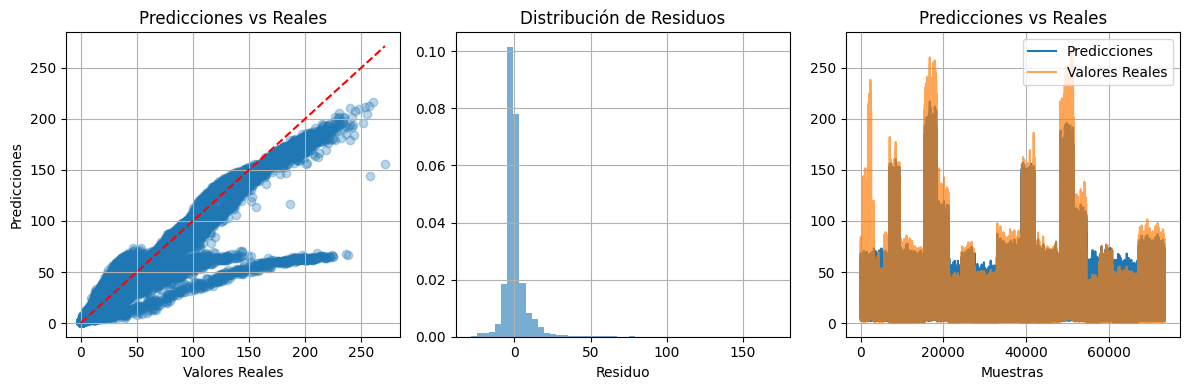

In [39]:
# Evaluación final del modelo global (o el mejor modelo guardado)
global_model.load_state_dict(torch.load(best_federated_model_path))
global_model.eval()
with torch.no_grad():
    y_pred = global_model(X_test_tensor).cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    mse = mean_squared_error(y_test_np, y_pred)
    mae = mean_absolute_error(y_test_np, y_pred)
    r2 = r2_score(y_test_np, y_pred)
    print("\n=== Evaluación Final del Mejor Modelo Federado ===")
    print(f"Test MSE: {mse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R2: {r2:.4f}")

# (Opcional) Graficar resultados en Test
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.title('Predicciones vs Reales')
plt.scatter(y_test_np, y_pred, alpha=0.3)
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.grid(True)

plt.subplot(132)
residuals = y_test_np - y_pred
plt.hist(residuals, bins=50, density=True, alpha=0.6)
plt.title('Distribución de Residuos')
plt.xlabel('Residuo')
plt.grid(True)

plt.subplot(133)
plt.plot(y_pred, label="Predicciones")
plt.plot(y_test_np, label="Valores Reales", alpha=0.7)
plt.title('Predicciones vs Reales')
plt.xlabel('Muestras')
plt.legend() 
plt.grid(True)
plt.tight_layout()
plt.show()